sentiment analysis over time

volume of tweets

do group comparison of the first three days versus all other days of the convention. Then shift the window one day and analyze again. Over and over throughout the convention. 

maybe display the top five words by index throughout the convention. 


###  Issues to address

deal with carriage returns

tab-separator

deal with hashtags separators

### Import packages / setup

In [1]:
import datetime
import tweepy
from tweepy import OAuthHandler
import json
import pandas as pd
import csv
import re
import string
import os
import time
import random
import numpy as np
from nltk.corpus import stopwords
sw = stopwords.words('english')
from string import punctuation
from collections import Counter, defaultdict
from pprint import pprint
from operator import itemgetter
import matplotlib.pyplot as plt


# I've put my API keys in a .py file called API_keys.py
from my_api_keys import api_key, api_key_secret, access_token, access_token_secret

In [2]:
# Authenticate the Tweepy API
auth = tweepy.OAuthHandler(api_key,api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

In [3]:
# Modifications to punctuation and sw lists

punctuation = set(punctuation)
punctuation.add("’")

sw2 = set(sw)
addl = ("|","-","/","•","&", "&amp;")
sw2.update(addl)

####  Read daily tweets CSVs into pandas dataframe

In [4]:
db = pd.DataFrame(columns = ['user_id','screen_name','description','location','friends_count',
           'followers_count','totaltweets','date_created', 'tweet_id', 'retweetcount','full_text'])

file_location = "/Users/natebender/Desktop/Repo/text-mining/datashare_AA_COP_tweets/data/"
files = sorted(os.listdir(file_location))
for idx, file in enumerate(files):
    
    data = "".join([file_location,file])
    datafile = pd.read_csv(data)

    db = db.append(datafile,ignore_index=True)

In [5]:
# Check desc stats on overall descriptions before splitting into groups
def get_patterns(all_tweets) :

    all_desc = all_tweets.dropna()
    all_str = " ".join(all_desc)    
    clean = [w for w in all_str.split() if w.lower() not in sw2]
    
    # Calculate your statistics here
    total_tokens = len(clean)
    unique_tokens = len(set(clean))
    clean_tok_len = [len(w) for w in clean]
    avg_token_len = np.mean(clean_tok_len)
    lex_diversity = len(set(clean))/len(clean)
    top_n = Counter(clean).most_common(20)
    
    
    # Now we'll fill out the dictionary. 
    results = {'tokens':total_tokens,
               'unique_tokens':unique_tokens,
               'avg_token_length':round(avg_token_len,2),
               'lexical_diversity':round(lex_diversity,2),
               'Top_n':top_n}

    return(results)

### Desc stats on database

In [6]:
# Drop NA values from description column
all_tweets = db.full_text.dropna()
print(f'Database: {"{:,}".format(len(db.tweet_id))} tweets')
#print(f'Date range: {db.date_created.min()} to {db.date_created.max()}')
print(f'Descriptive stats are:')
get_patterns(all_tweets)

Database: 285,084 tweets
Descriptive stats are:


{'tokens': 5523996,
 'unique_tokens': 170153,
 'avg_token_length': 7.82,
 'lexical_diversity': 0.03,
 'Top_n': [('#COP26', 227147),
  ('climate', 57446),
  ('#COP26Glasgow', 24133),
  ('world', 20434),
  ('#cop26', 18871),
  ('need', 18435),
  ('fossil', 17574),
  ('change', 15756),
  ('#Unknown', 15720),
  ('leaders', 14933),
  ('people', 13392),
  ('#ClimateAction', 13153),
  ('Climate', 12960),
  ('Glasgow', 12833),
  ('global', 11994),
  ('action', 11760),
  ('#ClimateCrisis', 11448),
  ('#COP26.', 10836),
  ('us', 10811),
  ('like', 10464)]}

### Lexicon expansion function to analyze tweets by time series window

In [159]:
class Lexicon_time :
    def __init__(self, corpus, search_condition, num_words, ratio_cutoff):
        self.corpus = list(corpus)
        self.search_condition = search_condition
        self.num_words = num_words
        self.ratio_cutoff = ratio_cutoff
        
    def parameters(self) :
        print(f'The corpus is {"{:,}".format(len(self.corpus))} total tweets')
        print(f"The search string is {self.search_condition}")
        print(f"Words must appear {self.ratio_cutoff} times in both corpora to be included in analysis")
        print(f"Output for {self.num_words} words is returned")
        
    def lex_expansion(self) :

        # Set starting marker for keeping track of how long the function runs
        start_time = datetime.datetime.now()

        group_1 = self.search_condition

        group_1 = list(group_1)
        group_2 = [string for string in self.corpus if string not in group_1]

        group_1_tweets = ("{:,}".format(len(group_1)))
        group_2_tweets = ("{:,}".format(len(group_2)))    

        # Tokenize the two groups by first turning them each into single large strings
        g1_str = " ".join(group_1)    
        g2_str = " ".join(group_2)

        # Then splitting each into lists of strings. Once we've created groups, we no longer need to know
        # which words came from which specific tweets, as long as we keep track of which group the 
        # words come from.
        # We also tokenize and normalize at this stage. We want to remove stopwords, but retain numeric as numbers
        # could be used in interesting words, hashtags, or accounts in a corpus of tweets. 
        g1_uclean = [w for w in g1_str.split()]
        g2_uclean = [w for w in g2_str.split()]

        g1_clean = [w for w in g1_str.split() if w.lower() not in sw2]
        g2_clean = [w for w in g2_str.split()if w.lower() not in sw2]

        g1_len = len(g1_clean)
        g2_len = len(g2_clean)

        # SECT2: CREATE "CUTOFF_LIST" LIST OF WORDS THAT MEET CUTOFF RATIO
        # Create Counter dictionary of each corpus, used for determining words that meet cutoff ratio
        wcount_one = Counter(g1_clean)
        wcount_two = Counter(g2_clean)

        # Create list of words that meet the ratio cutoff in BOTH corpora, print result
        cutoff_list = list()
        candidate_words = list(wcount_one.keys()) + list(wcount_two.keys())
        candidate_words = set(candidate_words)
        for word in candidate_words :
            if wcount_one[word] >= self.ratio_cutoff and wcount_two[word] >= self.ratio_cutoff :
                cutoff_list.append(word)

        cutoff_statement = f'There are {"{:,}".format(len(cutoff_list))} words that meet the usage cutoff of {self.ratio_cutoff} appearances in both Group 1 and Group 2'

        # SECT3: CALCULATE METRICS ON WORDS IN CUTOFF_LIST
        # Create "metrics", an intermediate dict to hold data that will be passed 
        # to different dictionaries in the final "results" dict of dicts output
        metrics = defaultdict(list)

        for word in cutoff_list:        
            metrics[word].append(len([w for w in g1_clean if w==word]))  # word count in corpus_1
            metrics[word].append(len([w for w in g2_clean if w==word]))  # word count in corpus_2
            metrics[word].append(len([w for w in g1_clean if w==word])/g1_len)  # ratio of word count to corpus_1 length
            metrics[word].append(len([w for w in g2_clean if w==word])/g2_len)  # ratio of word count to corpus_2 length 

        # Loop through through the defaultdict and append word ratio for the each word of the corpus
        for word, nums in metrics.items() :
            # Make sure any zero ratios are excluded
            if (nums[2] * nums[3] > 0) :
                metrics[word].append(nums[2]/nums[3])  # appends Corpus_1/Corpus_2 index
                metrics[word].append(nums[3]/nums[2])  # appends Corpus_2/Corpus_1 index
            else :
                metrics[word].append(None)
                metrics[word].append(None)


        # SECT4: APPEND RESPECTIVE INDEXES (CORP1/CORP2 RATIO AND CORP2/CORP1 RATIO) TO "METRICS" DICT
        one_v_two = defaultdict(list)
        two_v_one = defaultdict(list)

        # Append word/index pair in "one_v_two" dict
        for word, nums in metrics.items() :
            one_v_two[word].append(nums[4])

        # Sort "one_v_two" down to just the "num_words" key:value pairs,
        # sorted in descending order of index ratio.
        one_v_two_sort = dict(sorted(one_v_two.items(), key = itemgetter(1), reverse = True)[:self.num_words])

        # Lastly, round those values to two decimal points for readability    
        for dict_value in one_v_two_sort :
            for k, v in one_v_two_sort.items() :
                one_v_two_sort[k] = [round(v,2) for v in one_v_two_sort[k]]

        # Same process for "two_v_one"
        # Append word/index pair in "two_v_one" dict
        for word, nums in metrics.items() :
            two_v_one[word].append(nums[5])

        # Sort "two_v_one" down to just the "num_words" key:value pairs, 
        # sorted in descending order of index ratio.
        two_v_one_sort = dict(sorted(two_v_one.items(), key = itemgetter(1), reverse = True)[:self.num_words])         

        # Lastly, round those values to two decimal points for readability    
        for dict_value in two_v_one_sort :
            for k, v in two_v_one_sort.items() :
                two_v_one_sort[k] = [round(v,2) for v in two_v_one_sort[k]]      


        # SECT5: CALCULATE METRICS FOR "CORP1" AND "CORP2" KEYS IN "RESULTS" FINAL DICT
        # Descriptive stats calcs for corpus_1
        total_tokens_1 = len(g1_clean)
        unique_tokens_1 = len(set(g1_clean))
        word_len_1 = [len(w) for w in g1_clean]
        avg_token_len_1 = np.mean(word_len_1)
        lex_diversity_1 = len(set(g1_clean))/len(g1_clean)
        top_n_1 = Counter(g1_clean).most_common(self.num_words)

        # Descriptive stats calcs for corpus_2
        total_tokens_2 = len(g2_clean)
        unique_tokens_2 = len(set(g2_clean))
        word_len_2 = [len(w) for w in g2_clean]
        avg_token_len_2 = np.mean(word_len_2)
        lex_diversity_2 = len(set(g2_clean))/len(g2_clean)
        top_n_2 = Counter(g2_clean).most_common(self.num_words)


        # SECT6: BRING EVERYTHING TOGETHER IN "RESULTS" FINAL DICT
        results1 = {'Group_1': {'Number_of_tweets':group_1_tweets,
                                'Number_of_words':total_tokens_1,
                              'Unique_words':unique_tokens_1,
                              'Avg _length':round(avg_token_len_1, 2),
                              'Lexical_diversity':round(lex_diversity_1, 2),
                              'Top_'+str(self.num_words):top_n_1},
                   'Group_2': {'Number_of_tweets':group_2_tweets,
                               'Number_of_words':total_tokens_2,
                              'Unique_words':unique_tokens_2,
                              'Avg_word_length':round(avg_token_len_2, 2),
                              'Lexical_diversity':round(lex_diversity_2, 2),
                              'Top_'+str(self.num_words):top_n_2},
                   'Group1_vs_Group2': one_v_two_sort,
                   'Group2_vs_Group1': two_v_one_sort,
                   'cutoff_statement': cutoff_statement}

        # Print elapsed time after function has run
        end_time = datetime.datetime.now()
        elapsed_time = end_time - start_time
        print(elapsed_time)
        return(results1)

#### Breaking groups by date range

In [160]:
len(all_tweets)

180000

In [91]:
# Subset dataframe to multiple 3-day windows

w1_text = db.full_text[(db['date_created']>= "2021-10-28") & (db['date_created']< "2021-10-31")]
w2_text = db.full_text[(db['date_created']>= "2021-10-29") & (db['date_created']< "2021-11-01")]
w3_text = db.full_text[(db['date_created']>= "2021-10-30") & (db['date_created']< "2021-11-02")]
w4_text = db.full_text[(db['date_created']>= "2021-10-31") & (db['date_created']< "2021-11-03")]
w5_text = db.full_text[(db['date_created']>= "2021-11-01") & (db['date_created']< "2021-11-04")]
w6_text = db.full_text[(db['date_created']>= "2021-10-02") & (db['date_created']< "2021-11-05")]
w7_text = db.full_text[(db['date_created']>= "2021-10-03") & (db['date_created']< "2021-11-06")]
w8_text = db.full_text[(db['date_created']>= "2021-10-04") & (db['date_created']< "2021-11-07")]
w9_text = db.full_text[(db['date_created']>= "2021-10-05") & (db['date_created']< "2021-11-08")]
# w10_text = db.full_text[(db['date_created']>= "2021-10-06") & (db['date_created']< "2021-11-09")]
# w11_text = db.full_text[(db['date_created']>= "2021-10-07") & (db['date_created']< "2021-11-10")]
# w12_text = db.full_text[(db['date_created']>= "2021-10-08") & (db['date_created']< "2021-11-11")]
# w13_text = db.full_text[(db['date_created']>= "2021-10-09") & (db['date_created']< "2021-11-12")]
# w14_text = db.full_text[(db['date_created']>= "2021-10-10") & (db['date_created']< "2021-11-13")]
# w15_text = db.full_text[(db['date_created']>= "2021-10-11") & (db['date_created']< "2021-11-14")]
# w16_text = db.full_text[(db['date_created']>= "2021-10-12") & (db['date_created']< "2021-11-15")]

In [161]:
window1 = Lexicon_time(all_tweets, w1_text, 20, 10)
win1 = window1.lex_expansion()

1:12:45.664241


In [162]:
print(f'Group 1 tweets:')
print(win1['Group_1']['Number_of_tweets'])
print(f'Group 2 tweets:')
print(win1['Group_2']["Number_of_tweets"])
print(win1["cutoff_statement"])

Group 1 tweets:
45,000
Group 2 tweets:
133,968
There are 8,436 words that meet the usage cutoff of 10 appearances in both Group 1 and Group 2


In [163]:
print(f'Round 1: Group 1 v Group 2:')
pprint(sorted(win1['Group1_vs_Group2'].items(), key = itemgetter(1), reverse = True))

Round 1: Group 1 v Group 2:
[('#LetsGetReal', [230.4]),
 ('#XiJinping', [132.87]),
 ('Empty', [119.07]),
 ('#ScottishIndependence14', [95.84]),
 ('@Plant_Treaty', [91.97]),
 ('endorse', [76.67]),
 ('#EndFossilFinance', [69.7]),
 ('prepares', [66.8]),
 ('fuels?', [60.02]),
 ('act!', [57.36]),
 ('Pls', [55.76]),
 ('help!', [53.73]),
 ('option!', [52.28]),
 ('factory', [50.53]),
 ('NOW.', [46.1]),
 ('vague', [42.69]),
 ('REAL', [42.35]),
 ('pledges.', [39.37]),
 ('@s_guilbeault:', [36.59]),
 ('accepting', [36.3])]


In [165]:
window2 = Lexicon_time(all_tweets, w2_text, 20, 10)
win2 = window2.lex_expansion()

1:01:58.618177


In [166]:
print(f'Group 1 tweets:')
print(win2['Group_1']['Number_of_tweets'])
print(f'Group 2 tweets:')
print(win2['Group_2']["Number_of_tweets"])
print(win2["cutoff_statement"])

Group 1 tweets:
45,000
Group 2 tweets:
133,200
There are 8,440 words that meet the usage cutoff of 10 appearances in both Group 1 and Group 2


In [168]:
print(f'Round 2: Group 1 v Group 2:')
pprint(sorted(win2['Group1_vs_Group2'].items(), key = itemgetter(1), reverse = True))

Round 2: Group 1 v Group 2:
[('#ScottishIndependence14', [202.28]),
 ('#BanTrophyHunting', [143.4]),
 ('fuels?', [99.63]),
 ('#G20RomeSummit', [78.5]),
 ('prepares', [72.46]),
 ('#EndFossilFinance', [56.61]),
 ('option!', [54.34]),
 ('#PlantBasedTreaty', [38.12]),
 ('accepting', [37.74]),
 ('endorse', [34.58]),
 ('@HarjitSajjan', [33.21]),
 ('privatised', [33.21]),
 ('✍️', [31.87]),
 ('#Shorts', [31.7]),
 ('@Plant_Treaty', [29.85]),
 ('Peter', [29.28]),
 ('counts.', [28.68]),
 ('😷/', [28.68]),
 ('talks:', [28.68]),
 ('#Insiders', [28.18])]


In [175]:
test = sorted(win2['Group1_vs_Group2'].items(), key = itemgetter(1), reverse = True)
test2 = test[0][1][0]  # example of how to access the value for "scottishIndependence14"

In [169]:
window3 = Lexicon_time(all_tweets, w3_text, 20, 10)
win3 = window3.lex_expansion()

KeyboardInterrupt: 

In [ ]:
print(f'Group 1 tweets:')
print(win3['Group_1']['Number_of_tweets'])
print(f'Group 2 tweets:')
print(win3['Group_2']["Number_of_tweets"])
print(win3["cutoff_statement"])

In [ ]:
print(f'Round 3: Group 1 v Group 2:')
pprint(sorted(win3['Group1_vs_Group2'].items(), key = itemgetter(1), reverse = True))

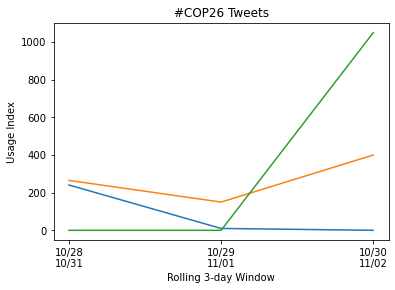

In [164]:
# Plantbasedtreaty    
x = [1, 2, 3]
y = [240.71, 10, 0]
plt.plot(x, y)
  
# Letsgetreal    
x1 = [1, 2, 3]
y1 = [265.23, 150, 400] 
# second plot with x1 and y1 data
plt.plot(x1, y1)
  
# example    
x2 = [1, 2, 3]
y2 = [0, 0, 1050] 
# second plot with x1 and y1 data
plt.plot(x2, y2)    

plt.xlabel("Rolling 3-day Window")
plt.ylabel("Usage Index")
plt.title('#COP26 Tweets')
plt.xticks([1, 2, 3], ["10/28\n10/31", "10/29\n11/01", "10/30\n11/02"])
plt.show()

- Figure out how to populate the x and y axes automatically from the dictionary of results for each iteration. 
- Add labels of the word names
- Add slider bar for the x axis to it can be interactive? User could slide the bar back and forth to more easily see how the usage changed throughout the conference. Bold items that correspond to the window the slider is on. 
- Add add'l layer of interactivity (toggle on/off?) that brings in info about what was being emphasized at different point of the conference. 

<hr style="border:2px solid gray"> </hr> 

<hr style="border:2px solid gray"> </hr> 

# Lexicon expansion function to analyze tweets by group

#### ROUND 1
<hr style="border:2px solid gray"> </hr> 

#### Breaking groups by search terms

r"#[copCOP]+26"


In [ ]:
class Lexicon :
    def __init__(self, corpus, search_condition, num_words, ratio_cutoff):
        self.corpus = list(corpus)
        self.search_condition = search_condition
        self.num_words = num_words
        self.ratio_cutoff = ratio_cutoff
        
    def parameters(self) :
        print(f'The corpus is {"{:,}".format(len(self.corpus))} total tweets')
        print(f"The search string is {self.search_condition}")
        print(f"Words must appear {self.ratio_cutoff} times in both corpora to be included in analysis")
        print(f"Output for {self.num_words} words is returned")
        
    def lex_expansion(self) :

        # Set starting marker for keeping track of how long the function runs
        start_time = datetime.datetime.now()

        group_1 = []

        for string in self.corpus :
            if self.search_condition.search(string) :
                group_1.append(string)

        full_group_1 = list(group_1)        
        group_1 = list(set(group_1))
        group_2 = [string for string in self.corpus if string not in group_1]

        full_group_1_tweets = ("{:,}".format(len(full_group_1)))
        group_1_tweets = ("{:,}".format(len(group_1)))
        group_2_tweets = ("{:,}".format(len(group_2)))    

        # Tokenize the two groups by first turning them each into single large strings
        g1_str = " ".join(group_1)    
        g2_str = " ".join(group_2)

        # Then splitting each into lists of strings. Once we've created groups, we no longer need to know
        # which words came from which specific tweets, as long as we keep track of which group the 
        # words come from.
        # We also tokenize and normalize at this stage. We want to remove stopwords, but retain numeric as numbers
        # could be used in interesting words, hashtags, or accounts in a corpus of tweets. 
        g1_uclean = [w for w in g1_str.split()]
        g2_uclean = [w for w in g2_str.split()]

        g1_clean = [w for w in g1_str.split() if w.lower() not in sw2]
        g2_clean = [w for w in g2_str.split()if w.lower() not in sw2]

        g1_len = len(g1_clean)
        g2_len = len(g2_clean)

        # SECT2: CREATE "CUTOFF_LIST" LIST OF WORDS THAT MEET CUTOFF RATIO
        # Create Counter dictionary of each corpus, used for determining words that meet cutoff ratio
        wcount_one = Counter(g1_clean)
        wcount_two = Counter(g2_clean)

        # Create list of words that meet the ratio cutoff in BOTH corpora, print result
        cutoff_list = list()
        candidate_words = list(wcount_one.keys()) + list(wcount_two.keys())
        candidate_words = set(candidate_words)
        for word in candidate_words :
            if wcount_one[word] >= self.ratio_cutoff and wcount_two[word] >= self.ratio_cutoff :
                cutoff_list.append(word)

        cutoff_statement = f'There are {"{:,}".format(len(cutoff_list))} words that meet the usage cutoff of {self.ratio_cutoff} appearances in both Group 1 and Group 2'

        # SECT3: CALCULATE METRICS ON WORDS IN CUTOFF_LIST
        # Create "metrics", an intermediate dict to hold data that will be passed 
        # to different dictionaries in the final "results" dict of dicts output
        metrics = defaultdict(list)

        for word in cutoff_list:        
            metrics[word].append(len([w for w in g1_clean if w==word]))  # word count in corpus_1
            metrics[word].append(len([w for w in g2_clean if w==word]))  # word count in corpus_2
            metrics[word].append(len([w for w in g1_clean if w==word])/g1_len)  # ratio of word count to corpus_1 length
            metrics[word].append(len([w for w in g2_clean if w==word])/g2_len)  # ratio of word count to corpus_2 length 

        # Loop through through the defaultdict and append word ratio for the each word of the corpus
        for word, nums in metrics.items() :
            # Make sure any zero ratios are excluded
            if (nums[2] * nums[3] > 0) :
                metrics[word].append(nums[2]/nums[3])  # appends Corpus_1/Corpus_2 index
                metrics[word].append(nums[3]/nums[2])  # appends Corpus_2/Corpus_1 index
            else :
                metrics[word].append(None)
                metrics[word].append(None)


        # SECT4: APPEND RESPECTIVE INDEXES (CORP1/CORP2 RATIO AND CORP2/CORP1 RATIO) TO "METRICS" DICT
        one_v_two = defaultdict(list)
        two_v_one = defaultdict(list)

        # Append word/index pair in "one_v_two" dict
        for word, nums in metrics.items() :
            one_v_two[word].append(nums[4])

        # Sort "one_v_two" down to just the "num_words" key:value pairs,
        # sorted in descending order of index ratio.
        one_v_two_sort = dict(sorted(one_v_two.items(), key = itemgetter(1), reverse = True)[:self.num_words])

        # Lastly, round those values to two decimal points for readability    
        for dict_value in one_v_two_sort :
            for k, v in one_v_two_sort.items() :
                one_v_two_sort[k] = [round(v,2) for v in one_v_two_sort[k]]

        # Same process for "two_v_one"
        # Append word/index pair in "two_v_one" dict
        for word, nums in metrics.items() :
            two_v_one[word].append(nums[5])

        # Sort "two_v_one" down to just the "num_words" key:value pairs, 
        # sorted in descending order of index ratio.
        two_v_one_sort = dict(sorted(two_v_one.items(), key = itemgetter(1), reverse = True)[:self.num_words])         

        # Lastly, round those values to two decimal points for readability    
        for dict_value in two_v_one_sort :
            for k, v in two_v_one_sort.items() :
                two_v_one_sort[k] = [round(v,2) for v in two_v_one_sort[k]]      


        # SECT5: CALCULATE METRICS FOR "CORP1" AND "CORP2" KEYS IN "RESULTS" FINAL DICT
        # Descriptive stats calcs for corpus_1
        total_tokens_1 = len(g1_clean)
        unique_tokens_1 = len(set(g1_clean))
        word_len_1 = [len(w) for w in g1_clean]
        avg_token_len_1 = np.mean(word_len_1)
        lex_diversity_1 = len(set(g1_clean))/len(g1_clean)
        top_n_1 = Counter(g1_clean).most_common(self.num_words)

        # Descriptive stats calcs for corpus_2
        total_tokens_2 = len(g2_clean)
        unique_tokens_2 = len(set(g2_clean))
        word_len_2 = [len(w) for w in g2_clean]
        avg_token_len_2 = np.mean(word_len_2)
        lex_diversity_2 = len(set(g2_clean))/len(g2_clean)
        top_n_2 = Counter(g2_clean).most_common(self.num_words)


        # SECT6: BRING EVERYTHING TOGETHER IN "RESULTS" FINAL DICT
        results1 = {'Group_1': {'Full_tweets':full_group_1_tweets,
                                'Number_of_tweets':group_1_tweets,
                                'Number_of_words':total_tokens_1,
                              'Unique_words':unique_tokens_1,
                              'Avg _length':round(avg_token_len_1, 2),
                              'Lexical_diversity':round(lex_diversity_1, 2),
                              'Top_'+str(self.num_words):top_n_1},
                   'Group_2': {'Number_of_tweets':group_2_tweets,
                               'Number_of_words':total_tokens_2,
                              'Unique_words':unique_tokens_2,
                              'Avg_word_length':round(avg_token_len_2, 2),
                              'Lexical_diversity':round(lex_diversity_2, 2),
                              'Top_'+str(self.num_words):top_n_2},
                   'Group1_vs_Group2': one_v_two_sort,
                   'Group2_vs_Group1': two_v_one_sort,
                   'cutoff_statement': cutoff_statement}

        # Print elapsed time after function has run
        end_time = datetime.datetime.now()
        elapsed_time = end_time - start_time
        print(elapsed_time)
        return(results1)

In [43]:
search_1 = re.compile(r"activis[mt]\w?") # match either uppercase #COP26 or lowercase #cop26
r1 = Lexicon(all_tweets, search_1, 10, 5)

In [44]:
r1.parameters()

The corpus is 150,000 total tweets
The search string is re.compile('activis[mt]\\w?')
Words must appear 5 times in both corpora to be included in analysis
Output for 10 words is returned


In [45]:
round1 = r1.lex_expansion()

0:03:02.711628


In [46]:
print(f'Group 1 tweets:')
print(round1['Group_1']['Full_tweets'])
print(round1['Group_1']['Number_of_tweets'])
print(f'Group 2 tweets:')
print(round1['Group_2']["Number_of_tweets"])
print(round1["cutoff_statement"])

Group 1 tweets:
3,432
572
Group 2 tweets:
146,568
There are 253 words that meet the usage cutoff of 5 appearances in both Group 1 and Group 2


In [47]:
print(f'Round 1: Group 1 v Group 2:')
pprint(sorted(round1['Group1_vs_Group2'].items(), key = itemgetter(1), reverse = True))

Round 1: Group 1 v Group 2:
[('offsets,', [3047.26]),
 ('.@s_guilbeault', [2978.0]),
 ('defied', [1662.14]),
 ('fuels!', [1540.94]),
 ('@GreenpeaceCA', [1540.94]),
 ('heights', [1540.94]),
 ('tables', [727.19]),
 ('climate-safe', [623.3]),
 ('sailing', [484.79]),
 ('Bangladesh', [332.43])]


In [48]:
print(f'Round 1: Group 2 v Group 1:')
pprint(sorted(round1['Group2_vs_Group1'].items(), key = itemgetter(1), reverse = True))

Round 1: Group 2 v Group 1:
[('one', [5.11]),
 ('#ClimateCrisis', [4.0]),
 ('#COP26Glasgow', [3.54]),
 ('carbon', [3.07]),
 ('#ClimateEmergency', [3.05]),
 ('via', [2.79]),
 ('need', [2.67]),
 ('know', [2.6]),
 ('get', [2.55]),
 ('planet', [2.47])]


#### ROUND 2
<hr style="border:2px solid gray"> </hr> 

In [49]:
search_2 = re.compile(r"activis[mt]\w?|\bdefied|\boffsets?\b") # match either uppercase #COP26 or lowercase #cop26
r2 = Lexicon(all_tweets, search_2, 10, 5)

In [50]:
r2.parameters()

The corpus is 150,000 total tweets
The search string is re.compile('activis[mt]\\w?|\\bdefied|\\boffsets?\\b')
Words must appear 5 times in both corpora to be included in analysis
Output for 10 words is returned


In [51]:
round2 = r2.lex_expansion()

0:01:54.589681


In [52]:
print(f'Group 2 tweets:')
print(round2['Group_1']['Full_tweets'])
print(round2['Group_1']['Number_of_tweets'])
print(f'Group 2 tweets:')
print(round2['Group_2']["Number_of_tweets"])
print(round2["cutoff_statement"])

Group 2 tweets:
3,732
611
Group 2 tweets:
146,268
There are 268 words that meet the usage cutoff of 5 appearances in both Group 1 and Group 2


In [53]:
print(f'Round 2: Group 1 v Group 2:')
pprint(sorted(round2['Group1_vs_Group2'].items(), key = itemgetter(1), reverse = True))

Round 2: Group 1 v Group 2:
[('.@s_guilbeault', [2798.59]),
 ('fuels!', [1448.11]),
 ('@GreenpeaceCA', [1448.11]),
 ('heights', [1448.11]),
 ('tables', [683.38]),
 ('climate-safe', [585.75]),
 ('sailing', [455.58]),
 ('Bangladesh', [312.4]),
 ('YES', [286.37]),
 ('odds', [260.33])]


In [54]:
print(f'Round 2: Group 2 v Group 1:')
pprint(sorted(round2['Group2_vs_Group1'].items(), key = itemgetter(1), reverse = True))

Round 2: Group 2 v Group 1:
[('one', [5.44]),
 ('@COP26', [3.46]),
 ('#COP26Glasgow', [3.4]),
 ('#ClimateCrisis', [3.31]),
 ('#ClimateEmergency', [3.25]),
 ('emissions', [3.03]),
 ('know', [2.77]),
 ('get', [2.71]),
 ('end', [2.68]),
 ('Scotland', [2.51])]
